<a href="https://colab.research.google.com/github/Anyaoma/Buy_Sell_Hold_ML_Prediction/blob/main/Sell_Buy_Hold_ML_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BUY SELL PREDICTION OF STOCK PRICES

In [276]:
!pip install quantreo
!pip install ta

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats
import quantreo.features_engineering as fe
import quantreo.target_engineering as te
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.mosaicplot import mosaic


In [278]:
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import StackingClassifier

## LOAD DATA

In [279]:
aapl_data = pd.read_pickle("AAPL.pickle")
msft_data = pd.read_pickle("MSFT.pickle")
spy_data = pd.read_pickle("SPY.pickle")
spy_data.head()

,Spot_Open,Spot_Close,Spot_High,Spot_Low,PCT_EPS_1mo_Open,PCT_EPS_1mo_Close,PCT_EPS_1mo_High,PCT_EPS_1mo_Low,open_abs_gex,high_abs_gex,low_abs_gex,close_abs_gex,volume_abs_gex,open_net_gex,high_net_gex,low_net_gex,close_net_gex,volume_net_gex
timestamp,,,,,,,,,,,,,,,,,,
2023-04-03 09:36:00-04:00,409.5500,409.7405,409.78,409.4805,0.381196,0.381196,0.381196,0.381196,9.334125e+08,9.334125e+08,9.334125e+08,9.334125e+08,0.0,-6.169928e+05,-6.169928e+05,-6.169928e+05,-6.169928e+05,0.0
2023-04-03 09:37:00-04:00,409.7500,409.7700,409.79,409.6300,0.378447,0.378447,0.378447,0.378447,9.338911e+08,9.338911e+08,9.338911e+08,9.338911e+08,0.0,-6.173091e+05,-6.173091e+05,-6.173091e+05,-6.173091e+05,0.0
2023-04-03 09:38:00-04:00,409.7900,409.8100,409.87,409.7300,0.373660,0.373660,0.373660,0.373660,9.340051e+08,9.340051e+08,9.340051e+08,9.340051e+08,0.0,-6.173845e+05,-6.173845e+05,-6.173845e+05,-6.173845e+05,0.0
2023-04-03 09:39:00-04:00,409.8101,409.8400,409.86,409.7318,0.371429,0.371429,0.371429,0.371429,9.340507e+08,9.340507e+08,9.340507e+08,9.340507e+08,0.0,-6.174146e+05,-6.174146e+05,-6.174146e+05,-6.174146e+05,0.0
2023-04-03 09:40:00-04:00,409.8600,409.7899,409.91,409.7564,0.375319,0.375319,0.375319,0.375319,9.383326e+08,9.383326e+08,9.383326e+08,9.383326e+08,0.0,7.578217e+07,7.578217e+07,7.578217e+07,7.578217e+07,0.0


In [280]:
spy_data.columns == aapl_data.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [281]:
msft_data.columns == aapl_data.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

## DATA EXPLORATION

#### AAPL

In [282]:
aapl_data.describe()

,Spot_Open,Spot_Close,Spot_High,Spot_Low,PCT_EPS_1mo_Open,PCT_EPS_1mo_Close,PCT_EPS_1mo_High,PCT_EPS_1mo_Low,open_abs_gex,high_abs_gex,low_abs_gex,close_abs_gex,volume_abs_gex,open_net_gex,high_net_gex,low_net_gex,close_net_gex,volume_net_gex
count,167344.000000,167344.000000,167344.000000,167344.000000,167344.000000,167344.000000,167344.000000,167344.000000,1.673440e+05,1.673440e+05,1.673440e+05,1.673440e+05,167344.0,1.673440e+05,1.673440e+05,1.673440e+05,1.673440e+05,167344.0
mean,194.989616,194.989811,195.059824,194.917603,0.425103,0.425103,0.425103,0.425103,3.220234e+08,3.220234e+08,3.220234e+08,3.220234e+08,0.0,7.885718e+07,7.885718e+07,7.885718e+07,7.885718e+07,0.0
std,23.227401,23.227428,23.237530,23.216673,0.351264,0.351264,0.351264,0.351264,1.677172e+08,1.677172e+08,1.677172e+08,1.677172e+08,0.0,1.147375e+08,1.147375e+08,1.147375e+08,1.147375e+08,0.0
min,159.800000,159.810000,159.880000,159.780000,0.000118,0.000118,0.000118,0.000118,-4.584938e+00,-4.584938e+00,-4.584938e+00,-4.584938e+00,0.0,-6.654424e+08,-6.654424e+08,-6.654424e+08,-6.654424e+08,0.0
25%,176.146200,176.144750,176.220000,176.070000,0.073632,0.073632,0.073632,0.073632,2.177612e+08,2.177612e+08,2.177612e+08,2.177612e+08,0.0,1.438402e+07,1.438402e+07,1.438402e+07,1.438402e+07,0.0
50%,188.630000,188.629850,188.680000,188.570000,0.384215,0.384215,0.384215,0.384215,2.904250e+08,2.904250e+08,2.904250e+08,2.904250e+08,0.0,6.431056e+07,6.431056e+07,6.431056e+07,6.431056e+07,0.0
75%,218.610000,218.610000,218.720000,218.500025,0.768195,0.768195,0.768195,0.768195,3.980495e+08,3.980495e+08,3.980495e+08,3.980495e+08,0.0,1.314967e+08,1.314967e+08,1.314967e+08,1.314967e+08,0.0
max,254.225000,254.600000,255.000000,254.220000,1.000000,1.000000,1.000000,1.000000,7.546388e+09,7.546388e+09,7.546388e+09,7.546388e+09,0.0,3.668515e+09,3.668515e+09,3.668515e+09,3.668515e+09,0.0


absolute gamma exposure values contain negative value which shouldnt be

In [283]:
#check total negative absolute gamma values
sum(aapl_data['close_abs_gex'] <0)

40

In [284]:
aapl_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167344 entries, 2023-04-03 09:30:00-04:00 to 2024-12-20 15:59:00-05:00
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Spot_Open          167344 non-null  float64
 1   Spot_Close         167344 non-null  float64
 2   Spot_High          167344 non-null  float64
 3   Spot_Low           167344 non-null  float64
 4   PCT_EPS_1mo_Open   167344 non-null  float64
 5   PCT_EPS_1mo_Close  167344 non-null  float64
 6   PCT_EPS_1mo_High   167344 non-null  float64
 7   PCT_EPS_1mo_Low    167344 non-null  float64
 8   open_abs_gex       167344 non-null  float64
 9   high_abs_gex       167344 non-null  float64
 10  low_abs_gex        167344 non-null  float64
 11  close_abs_gex      167344 non-null  float64
 12  volume_abs_gex     167344 non-null  float64
 13  open_net_gex       167344 non-null  float64
 14  high_net_gex       167344 non-null  float64
 15  low_n

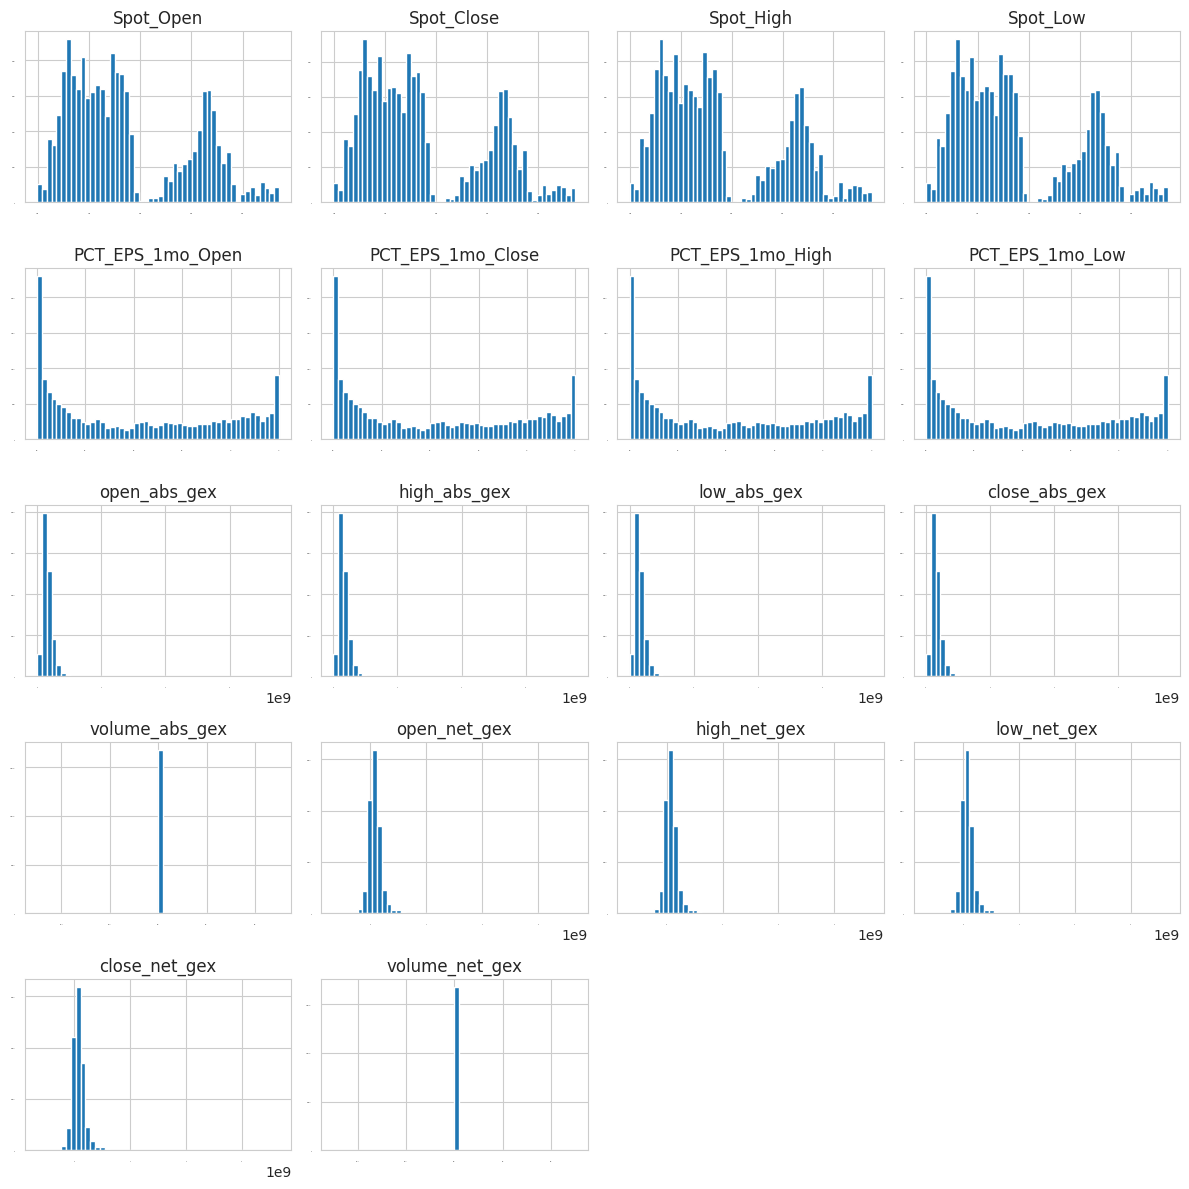

In [285]:
# Visualize aapl distribution
aapl_data.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.tight_layout()
plt.show()

The close, open, high and  low spot price of AAPL are multi modal. This indicates multiple regime influencing price. A regime detection model can be applied in order to predict and segregate each regime. The return, buy and sell signals can then be generated within each regime.

#### SPY

In [286]:
spy_data.describe()

,Spot_Open,Spot_Close,Spot_High,Spot_Low,PCT_EPS_1mo_Open,PCT_EPS_1mo_Close,PCT_EPS_1mo_High,PCT_EPS_1mo_Low,open_abs_gex,high_abs_gex,low_abs_gex,close_abs_gex,volume_abs_gex,open_net_gex,high_net_gex,low_net_gex,close_net_gex,volume_net_gex
count,166500.000000,166500.000000,166500.000000,166500.000000,166500.000000,166500.000000,166500.000000,166500.000000,1.665000e+05,1.665000e+05,1.665000e+05,1.665000e+05,166500.0,1.665000e+05,1.665000e+05,1.665000e+05,1.665000e+05,166500.0
mean,495.017645,495.017798,495.116255,494.915384,0.451943,0.451943,0.451943,0.451943,1.146558e+09,1.146558e+09,1.146558e+09,1.146558e+09,0.0,7.440525e+07,7.440525e+07,7.440525e+07,7.440525e+07,0.0
std,59.336326,59.335997,59.341300,59.330473,0.329833,0.329833,0.329833,0.329833,5.044058e+08,5.044058e+08,5.044058e+08,5.044058e+08,0.0,4.511821e+08,4.511821e+08,4.511821e+08,4.511821e+08,0.0
min,403.790000,403.795000,403.970000,403.740000,0.000118,0.000118,0.000118,0.000118,-7.000000e-06,-7.000000e-06,-7.000000e-06,-7.000000e-06,0.0,-2.228432e+09,-2.228432e+09,-2.228432e+09,-2.228432e+09,0.0
25%,440.910000,440.910000,440.980000,440.830000,0.136273,0.136273,0.136273,0.136273,8.192255e+08,8.192255e+08,8.192255e+08,8.192255e+08,0.0,-2.250616e+08,-2.250616e+08,-2.250616e+08,-2.250616e+08,0.0
50%,495.800000,495.800000,495.897500,495.692500,0.432922,0.432922,0.432922,0.432922,1.041204e+09,1.041204e+09,1.041204e+09,1.041204e+09,0.0,6.837704e+07,6.837704e+07,6.837704e+07,6.837704e+07,0.0
75%,545.815000,545.810000,545.920000,545.700000,0.762022,0.762022,0.762022,0.762022,1.337658e+09,1.337658e+09,1.337658e+09,1.337658e+09,0.0,3.548911e+08,3.548911e+08,3.548911e+08,3.548911e+08,0.0
max,609.015000,609.010000,609.070000,608.850000,1.000000,1.000000,1.000000,1.000000,3.771437e+09,3.771437e+09,3.771437e+09,3.771437e+09,0.0,2.705825e+09,2.705825e+09,2.705825e+09,2.705825e+09,0.0


In [287]:
#check total negative absolute gamma values
sum(spy_data['close_abs_gex'] <0)

1

In [288]:
spy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166500 entries, 2023-04-03 09:36:00-04:00 to 2024-12-20 15:59:00-05:00
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Spot_Open          166500 non-null  float64
 1   Spot_Close         166500 non-null  float64
 2   Spot_High          166500 non-null  float64
 3   Spot_Low           166500 non-null  float64
 4   PCT_EPS_1mo_Open   166500 non-null  float64
 5   PCT_EPS_1mo_Close  166500 non-null  float64
 6   PCT_EPS_1mo_High   166500 non-null  float64
 7   PCT_EPS_1mo_Low    166500 non-null  float64
 8   open_abs_gex       166500 non-null  float64
 9   high_abs_gex       166500 non-null  float64
 10  low_abs_gex        166500 non-null  float64
 11  close_abs_gex      166500 non-null  float64
 12  volume_abs_gex     166500 non-null  float64
 13  open_net_gex       166500 non-null  float64
 14  high_net_gex       166500 non-null  float64
 15  low_n

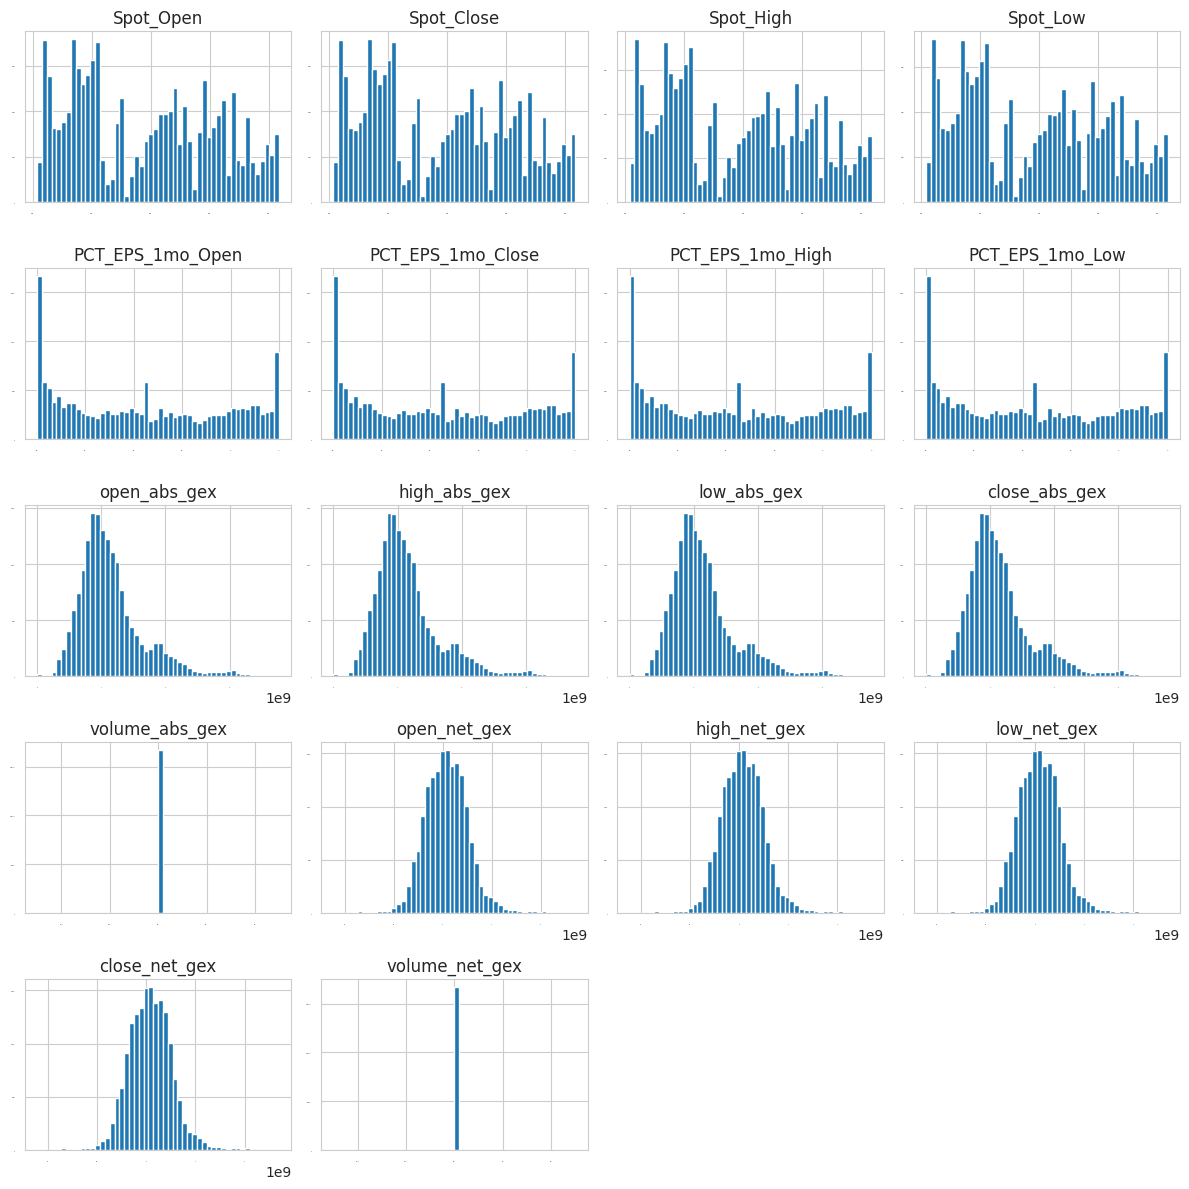

In [289]:
spy_data.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.tight_layout()
plt.show()

The close, open, high and low spot price of SPY are multi modal. This indicates multiple regime influencing price. A regime detection model can be applied in order to predict and segregate each regime. The return, buy and sell signals can then be generated within each regime.

#### MSFT

In [290]:
msft_data.describe()

,Spot_Open,Spot_Close,Spot_High,Spot_Low,PCT_EPS_1mo_Open,PCT_EPS_1mo_Close,PCT_EPS_1mo_High,PCT_EPS_1mo_Low,open_abs_gex,high_abs_gex,low_abs_gex,close_abs_gex,volume_abs_gex,open_net_gex,high_net_gex,low_net_gex,close_net_gex,volume_net_gex
count,165708.000000,165708.000000,165708.00000,165708.000000,165708.000000,165708.000000,165708.000000,165708.000000,1.657080e+05,1.657080e+05,1.657080e+05,1.657080e+05,165708.0,1.657080e+05,1.657080e+05,1.657080e+05,1.657080e+05,165708.0
mean,382.404506,382.404796,382.54143,382.266873,0.448472,0.448472,0.448472,0.448472,3.256352e+111,3.256352e+111,3.256352e+111,3.256352e+111,0.0,-1.261803e+111,-1.261803e+111,-1.261803e+111,-1.261803e+111,0.0
std,48.010349,48.010157,48.01765,48.003217,0.345300,0.345300,0.345300,0.345300,5.928064e+113,5.928064e+113,5.928064e+113,5.928064e+113,0.0,2.297064e+113,2.297064e+113,2.297064e+113,2.297064e+113,0.0
min,275.890000,275.560000,275.98000,275.370000,0.000118,0.000118,0.000118,0.000118,-6.126052e+00,-6.126052e+00,-6.126052e+00,-6.126052e+00,0.0,-4.183484e+115,-4.183484e+115,-4.183484e+115,-4.183484e+115,0.0
25%,333.830000,333.830000,333.95000,333.690000,0.106290,0.106290,0.106290,0.106290,9.026701e+07,9.026701e+07,9.026701e+07,9.026701e+07,0.0,3.418744e+06,3.418744e+06,3.418744e+06,3.418744e+06,0.0
50%,403.315350,403.320000,403.47250,403.167650,0.399442,0.399442,0.399442,0.399442,1.220314e+08,1.220314e+08,1.220314e+08,1.220314e+08,0.0,2.834847e+07,2.834847e+07,2.834847e+07,2.834847e+07,0.0
75%,420.770000,420.765000,420.93000,420.600000,0.785259,0.785259,0.785259,0.785259,1.746483e+08,1.746483e+08,1.746483e+08,1.746483e+08,0.0,6.273384e+07,6.273384e+07,6.273384e+07,6.273384e+07,0.0
max,468.300000,468.315000,468.35000,468.190000,1.000000,1.000000,1.000000,1.000000,1.079637e+116,1.079637e+116,1.079637e+116,1.079637e+116,0.0,4.387923e+08,4.387923e+08,4.387923e+08,4.387923e+08,0.0


The close, open, high and low spot price of MSFT are multi modal. This indicates multiple regime influencing price. A regime detection model can be applied in order to predict and segregate each regime. The return, buy and sell signals can then be generated within each regime.

This could be responsible for the large outliers

In [291]:
#check total negative absolute gamma values
sum(msft_data['close_abs_gex'] <0)

30

In [292]:
msft_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165708 entries, 2023-04-03 09:30:00-04:00 to 2024-12-20 15:59:00-05:00
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Spot_Open          165708 non-null  float64
 1   Spot_Close         165708 non-null  float64
 2   Spot_High          165708 non-null  float64
 3   Spot_Low           165708 non-null  float64
 4   PCT_EPS_1mo_Open   165708 non-null  float64
 5   PCT_EPS_1mo_Close  165708 non-null  float64
 6   PCT_EPS_1mo_High   165708 non-null  float64
 7   PCT_EPS_1mo_Low    165708 non-null  float64
 8   open_abs_gex       165708 non-null  float64
 9   high_abs_gex       165708 non-null  float64
 10  low_abs_gex        165708 non-null  float64
 11  close_abs_gex      165708 non-null  float64
 12  volume_abs_gex     165708 non-null  float64
 13  open_net_gex       165708 non-null  float64
 14  high_net_gex       165708 non-null  float64
 15  low_n

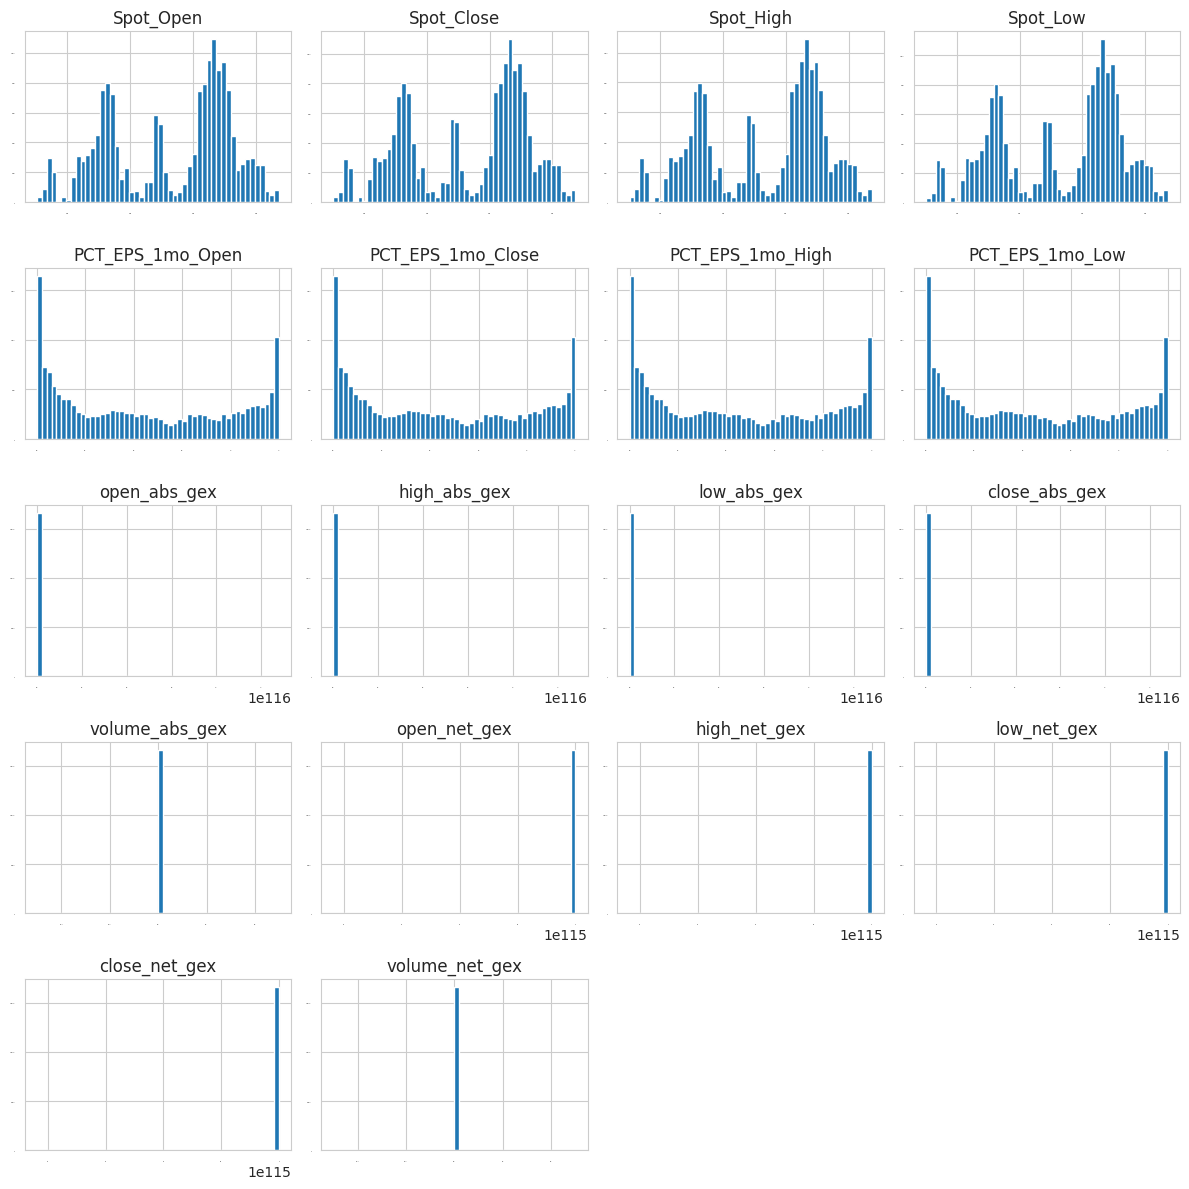

In [293]:
msft_data.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.tight_layout()
plt.show()

## DATA CLEANING, FEATURE AND TARGET ENGINEERING

In [404]:
def data_cleaning(df, asset_name):
    '''
    This names the asset, eliminates zero filled columns and unnecessary negative absolute gamma exposure values

    parameters:
    df: dataframe
    asset_name: str

    returns:
    df_copy: dataframe

    '''
    df_copy = df.copy()
    df_copy['asset_name'] = asset_name
    df_copy = df_copy.drop(df_copy[df_copy['close_abs_gex'] < 0].index) #remove rows with negative gamma exposure
    df_copy = df_copy.drop(columns=['volume_abs_gex','volume_net_gex'])
    df_copy = df_copy.rename(columns={'Spot_Open':'open','Spot_High':'high','Spot_Close':'close','Spot_Low':'low'})

    return df_copy

In [407]:

def ROC(df, n):
    '''
    Calculates the rate of change
    parameters:
    df: dataframe
    n: int

    returns:
    ROC: pd.Series
    '''
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC



def MOM(df, n):
    '''
    calculates the price momentum
    parameters:
    df: dataframe
    n: int

    returns:
    MOM: pd.Series

    '''
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM


def STOK(close, low, high, n):
    '''
    calculates the stochastic oscilator
    parameters:
    close: pd.Series
    low: pd.Series
    high: pd.Series
    n: int

    returns:
    STOK: pd.Series
    '''
    STOK = ((close - low.rolling(n).min()) /(high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK


def STOD(close, low, high, n):
    '''
    calculates the stochastic oscilator (smoothed version of STOK)
    parameters:
    close: pd.Series
    low: pd.Series
    high: pd.Series
    n: int

    returns:
    STOD: pd.Series
    '''
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

In [408]:
def features_engineering(df):
    '''
    Performs feature engineering

    parameters:
    df: dataframe

    returns:
    df_copy: dataframe
    '''

    df_copy = df.copy()

    log_close = np.log(df_copy['close'])
    df_copy['return'] = log_close - log_close.shift(10)
    df_copy['rolling_std'] = df_copy['close'].rolling(window=30).std()

    #Candle features
    df_copy['candle_way'], df_copy['filling'], df_copy['amplitude'] = fe.candle.candle_information(df_copy)

    roc10 = ROC(df_copy['close'], 10)
    roc30 = ROC(df_copy['close'], 30)
    df_copy['ROC_change'] = roc10 - roc30/roc30

    mom10 = MOM(df_copy['close'], 10)
    mom30 = MOM(df_copy['close'], 30)
    df_copy['MOM_change'] = mom10 - mom30/mom30

    stok10 = STOK(df_copy['close'], df_copy['low'], df_copy['high'], 10)
    stod10 = STOD(df_copy['close'], df_copy['low'], df_copy['high'], 10)
    stok30 = STOK(df_copy['close'], df_copy['low'], df_copy['high'], 30)
    stod30 = STOD(df_copy['close'], df_copy['low'], df_copy['high'], 30)
    df_copy['%K_change'] = stok10 - stok30/stok30
    df_copy['%D_change'] = stod10 - stod30/stod30
    df_copy['kama_(moving_average)'] = fe.trend.kama(df_copy, col='close')
    df_copy['kama_market_regime_indicator'] = fe.market_regime.kama_market_regime(df_copy,'close')


    #RSI calculations
    rsi14 = ta.momentum.rsi(df_copy['close'], window=14)
    rsi30 = ta.momentum.rsi(df_copy['close'], window=30)
    df_copy['RSI_change'] = rsi14 - rsi30/rsi30

    #Log returns and autocorrelation
    windows = [2, 5, 10, 20, 40, 60]
    for num in windows:
        df_copy[f'log_{num}_return'] = log_close - log_close.shift(num)
        df_copy[f'auto_corr_{num}'] = fe.math.auto_corr(df_copy, col='close', window_size=70, lag=num)

    df_copy["log_close"] = log_close
    df_copy["log_abs_gex"] = np.log(df_copy["close_abs_gex"].abs() + 1e-9)
    df_copy["log_gex_close"] = np.log(df_copy["close_net_gex"].abs() + 1e-9)


    # parkinson Volatility calculations
    vol30 = fe.volatility.parkinson_volatility(df_copy, window_size=30)
    vol60 = fe.volatility.parkinson_volatility(df_copy, window_size=60)
    df_copy['vol_parkinson_change'] = vol30 - vol60/vol60

    #GEX features
    #df_copy['gex_net_change'] = (df_copy['close_net_gex'] - df_copy['open_net_gex']) / abs(df_copy['open_net_gex']) produces zero on minute data
    gex_roll10 = df_copy['close_net_gex'].rolling(window=10, min_periods=1).mean()
    gex_roll30 = df_copy['close_net_gex'].rolling(window=30, min_periods=1).mean()
    df_copy['gex_rolling_net_ratio'] = (gex_roll10 - gex_roll30) / gex_roll30
    gex_roll10_abs = df_copy['close_abs_gex'].rolling(window=10, min_periods=1).mean()
    gex_roll30_abs = df_copy['close_abs_gex'].rolling(window=30, min_periods=1).mean()
    df_copy['gex_rolling_abs_ratio'] = (gex_roll10_abs - gex_roll30_abs) / gex_roll30_abs
    df_copy['gex_sign'] = np.where(df_copy['close_net_gex']>0, 1, 0)


    #Drop columns
    cols_to_drop = [
        'ROC10', 'ROC30', 'MOM10', 'MOM30', '%K10', '%K30', '%D10', '%D30',
        'RSI_14', 'RSI_30', 'vol_close_to_close_30', 'vol_close_to_close_60',
        'open_abs_gex', 'close_abs_gex', 'high_abs_gex', 'low_abs_gex',
        'open_net_gex', 'close_net_gex', 'high_net_gex', 'low_net_gex',
        'gex_rolling_10', 'gex_rolling_30'
    ]
    #drop columns that actually exist in the dataframe
    cols_to_drop = [col for col in cols_to_drop if col in df_copy.columns]
    df_copy.drop(columns=cols_to_drop, inplace=True)

    # Drop NA
    df_copy.dropna(inplace=True)

    return df_copy

In [409]:
def full_engineering(df, asset_name):
    '''
    Performs data cleaning, feature engineering and target engineering

    parameters:
    df: dataframe
    asset_name: str

    returns:
    df_copy: dataframe
    '''
    df_copy = df.copy()
    df_copy = data_cleaning(df_copy, asset_name)
    df_copy = features_engineering(df_copy)
    return df_copy

#### PERFORM FEATURE ENGINEERING

In [298]:
aapl_data = full_engineering(aapl_data,'AAPL')
msft_data = full_engineering(msft_data, 'MSFT')
spy_data= full_engineering(spy_data, 'SPY')

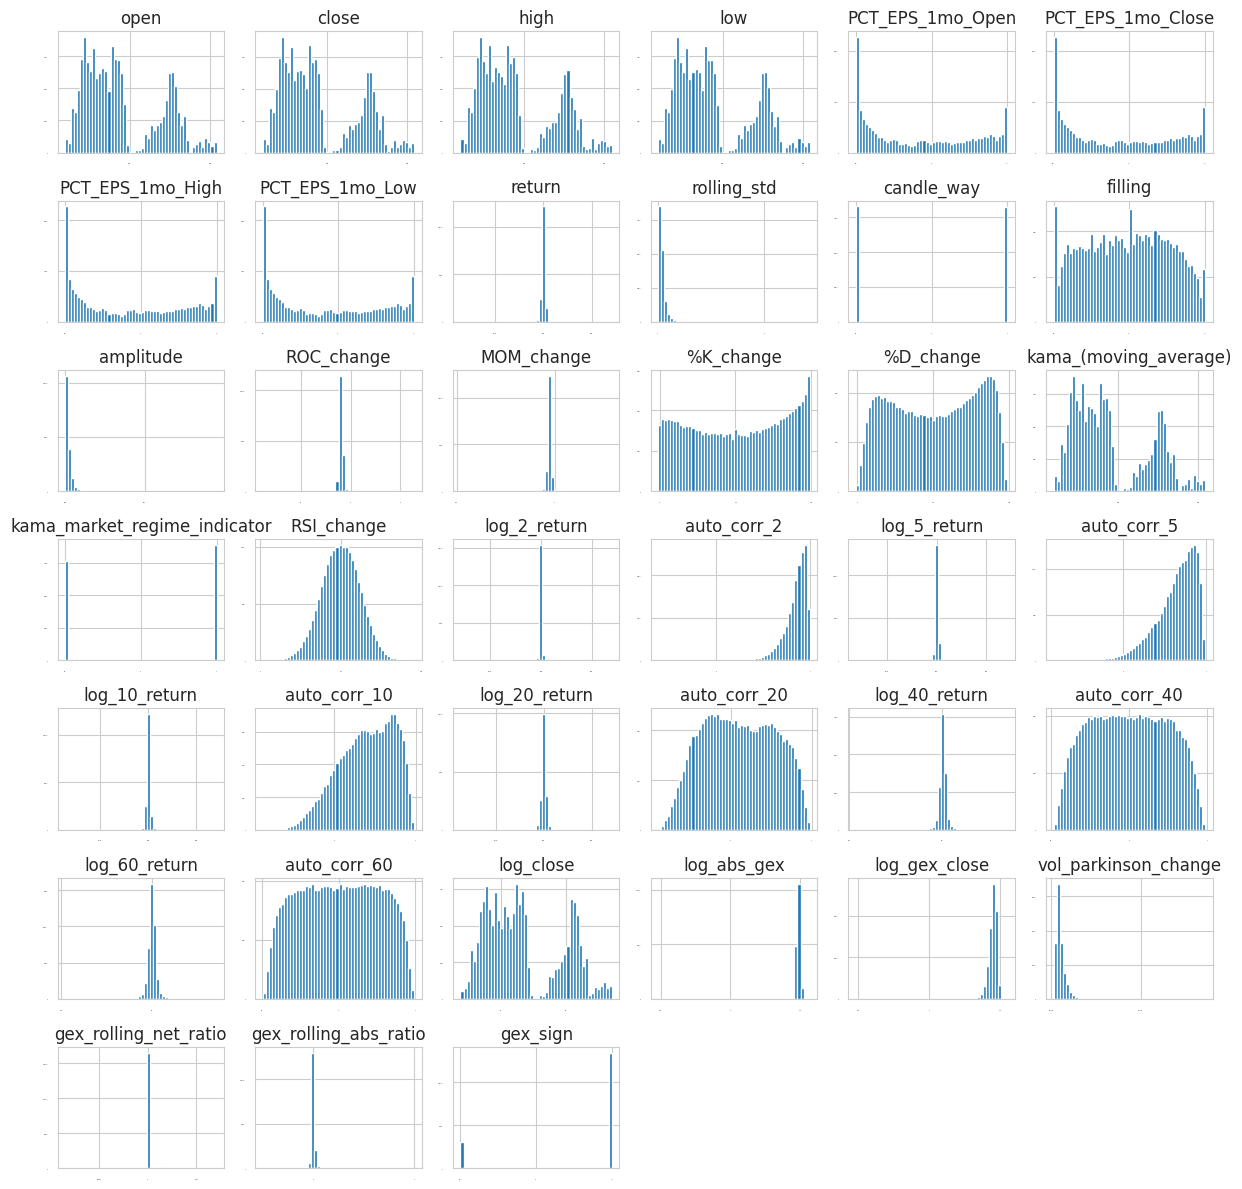

In [300]:
aapl_data.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.tight_layout()
plt.show()

#### CONFIRMATION OF MULTI MODAL ASSET PRICE DISTRIBUTION

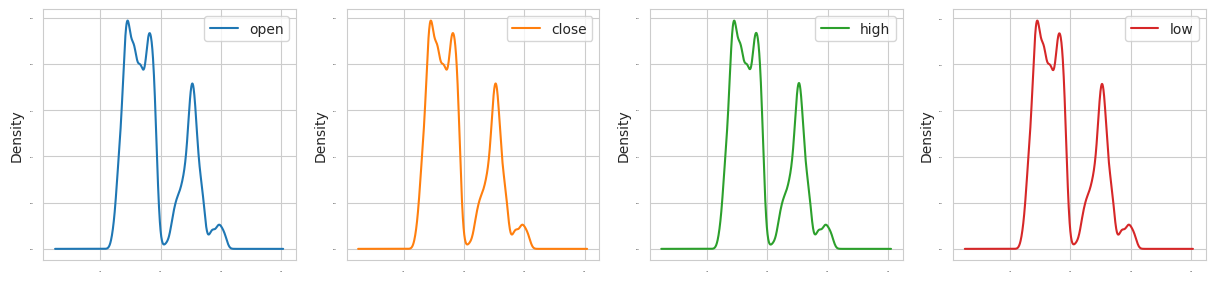

In [302]:
aapl_data[['open', 'close', 'high', 'low']].plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

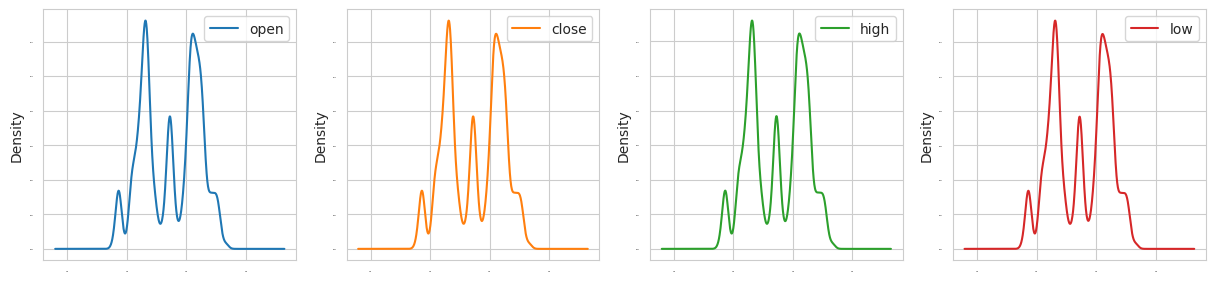

In [303]:
msft_data[['open', 'close', 'high', 'low']].plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

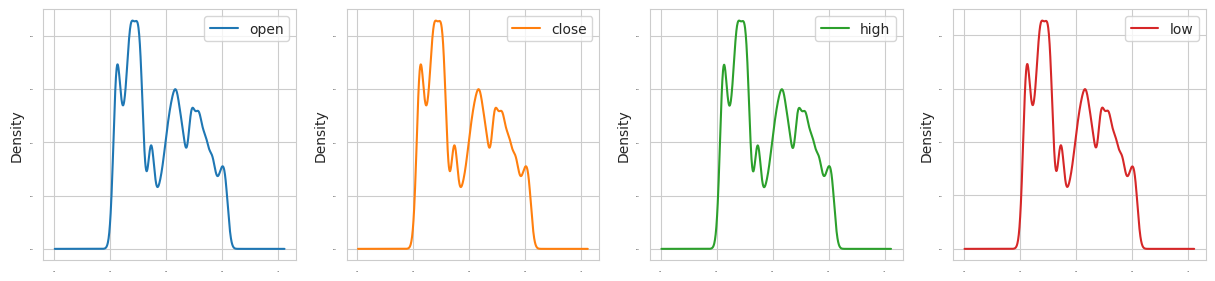

In [304]:
spy_data[['open', 'close', 'high', 'low']].plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

## Visualize returns

{'whiskers': [<matplotlib.lines.Line2D at 0x7f89660e9110>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8960fbe8d0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7f89658b52d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8960fbe650>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8960fbf310>],
 'means': []}

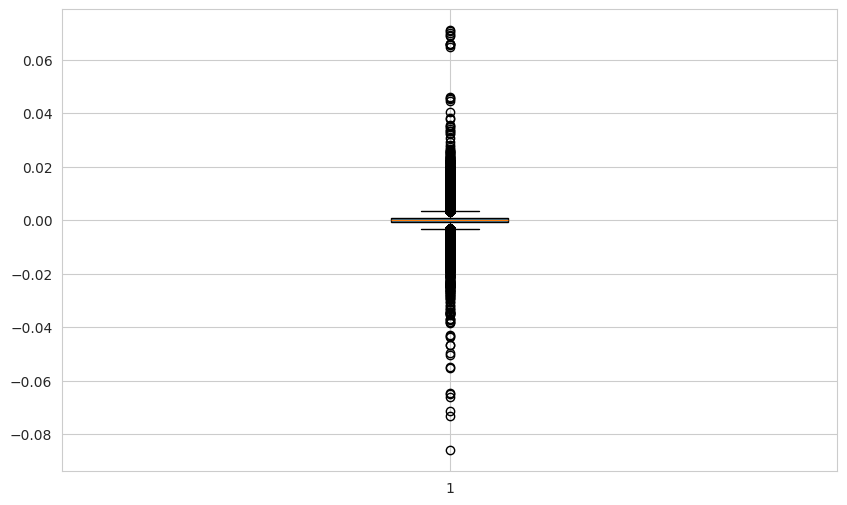

In [305]:
log_returns = aapl_data['return'].replace([np.inf, -np.inf], np.nan).dropna()  # Clean infinite values

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(log_returns, vert=True, patch_artist=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8965567850>,
 'caps': [<matplotlib.lines.Line2D at 0x7f89615ca010>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7f896172f850>],
 'medians': [<matplotlib.lines.Line2D at 0x7f89615c9d10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f89615cae90>],
 'means': []}

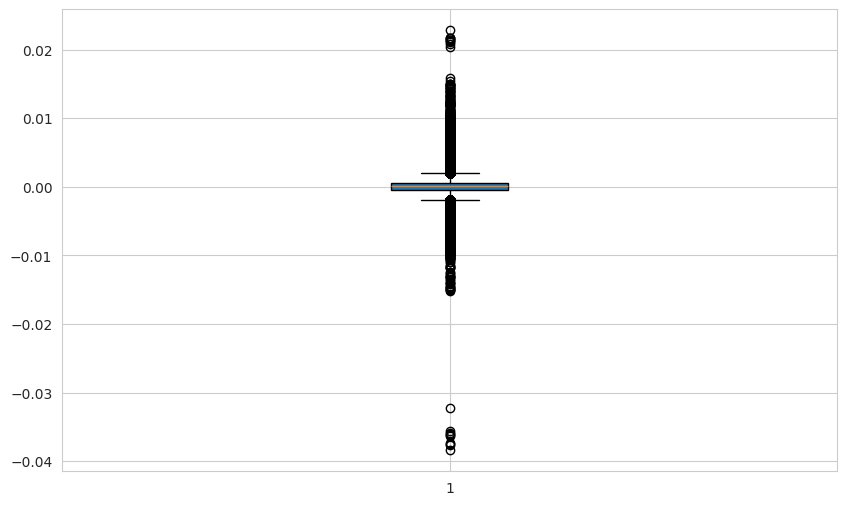

In [306]:
log_returns = spy_data['return'].replace([np.inf, -np.inf], np.nan).dropna()  # Clean infinite values

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(log_returns, vert=True, patch_artist=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8966f33d10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8965aedc50>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7f89660e9450>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8965aed4d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8965aee950>],
 'means': []}

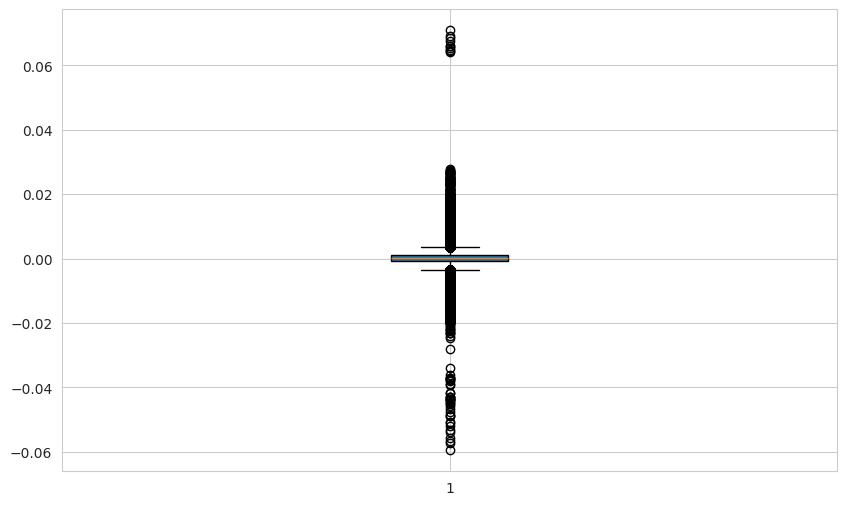

In [307]:
log_returns = msft_data['return'].replace([np.inf, -np.inf], np.nan).dropna()  # Clean infinite values

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(log_returns, vert=True, patch_artist=True)

## TRAIN TEST SPLIT

In [308]:

aapl_train = aapl_data.iloc[:int(len(aapl_data) * 0.70),:]
aapl_test = aapl_data.iloc[int(len(aapl_data) * 0.70):,:]

msft_train = msft_data.iloc[:int(len(msft_data) * 0.70),:]
msft_test = msft_data.iloc[int(len(msft_data) * 0.70):,:]

spy_train = spy_data.iloc[:int(len(spy_data) * 0.70),:]
spy_test = spy_data.iloc[int(len(spy_data) * 0.70):,:]

##  REGIME DETECTION

#### STEP 1: PREDICT REGIMES FOR TRAIN AND TEST SET

In [352]:
def regime_detection(df_train, df_test):
    '''
    Computes the different regimes present in the data and returns the train and test set with the regime labels.

    Parameters:
    df_train (pd.DataFrame): The training dataset.
    df_test (pd.DataFrame): The testing dataset.

    Returns:
    train_df (pd.DataFrame): The training dataset with the regime labels.
    test_df (pd.DataFrame): The testing dataset with the regime labels.

    '''
    df_train_comb = df_train.copy()
    df_test_comb = df_test.copy()

    #store asset name
    asset_name = df_train_comb['asset_name'].iloc[0]

    col_drop = ['open','high','low','close','asset_name']
    list_X = [col for col in df_train_comb.columns if col not in col_drop]
    # Make a copy of the dataframe and drop rows with NA values
    df_train = df_train_comb.copy()
    df_train = df_train[list_X].dropna()
    X_train = df_train[~np.isinf(df_train).any(axis=1)]

    # Store the index before scaling
    train_index = X_train.index

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    # Fit GMM with optimal cluster number
    n_regimes = 3  # Determine via BIC/AIC analysis
    gmm = GaussianMixture(n_components=n_regimes, random_state=42)
    regimes = gmm.fit_predict(X_train_scaled)

    # Create a new DataFrame with the index and regime
    df_train = pd.DataFrame({'regime': regimes}, index=train_index)
    # Add back the original columns (including 'return') from the original data
    df_train = df_train_comb.loc[df_train.index].join(df_train['regime'])


    # DERIVE TEST REGIME VALUES
    df_test = df_test_comb.copy()
    df_test= df_test[list_X].dropna()
    X_test = df_test[~np.isinf(df_test).any(axis=1)]

    test_index = X_test.index
    X_test_scaled = scaler.transform(X_test)  #use train scaler
    # Predict regimes using TRAINED GMM
    test_regimes = gmm.predict(X_test_scaled)

    # Create test DataFrame with index
    df_test = pd.DataFrame({'regime': test_regimes}, index=test_index)
    df_test = df_test_comb.loc[df_test.index].join(df_test['regime'])

#TEP 2: DEFINE THE QUANTILE THRESHOLDS FOR EACH REGIME

    BUY_QUANTILE = 0.90  # Top 10% returns = buy signal
    SELL_QUANTILE = 0.10  # Bottom 10% returns = sell signal

    # Calculate static thresholds per regime
    regime_thresholds = df_train.groupby('regime')['return'].agg([
            ('buy_threshold', lambda x: x.quantile(BUY_QUANTILE)),
            ('sell_threshold', lambda x: x.quantile(SELL_QUANTILE))
        ]).reset_index()

    print(f"Regime-Specific Thresholds: {asset_name}")
    print(regime_thresholds)

# STEP 3: MERGE THE THRESHOLD WITH TRAIN AND TEST DATA

    # Merge thresholds back to training data
    train_df = df_train.merge(regime_thresholds, on='regime', how='left')
    train_df.index = df_train.index
    # Generate signals
    train_df['signal'] = np.where(train_df['return'] > train_df['buy_threshold'], 1,
                                  np.where(train_df['return'] < train_df['sell_threshold'], -1, 0))


    # Merge the TRAINED regime thresholds to test set
    test_df = df_test.merge(regime_thresholds, on='regime', how='left')
    test_df.index = df_test.index
    # Generate signals using same thresholds
    test_df['signal'] = np.where(test_df['return'] > test_df['buy_threshold'], 1,
                                np.where(test_df['return'] < test_df['sell_threshold'], -1, 0))

    #Generate labels for train set
    train_df['future_return'] = np.log(train_df['close'].shift(-10) / train_df['close'])  # 10-period forward return

    train_df['label'] = np.where(
    train_df['future_return'] > train_df['buy_threshold'], 1,
    np.where(train_df['future_return'] < train_df['sell_threshold'], -1, 0))

    #Generate labels for test set
    test_df['future_return'] = np.log(test_df['close'].shift(-10) / test_df['close'])  # 10-period forward
    test_df['label'] = np.where( test_df['future_return'] > test_df['buy_threshold'], 1,
    np.where(test_df['future_return'] < test_df['sell_threshold'], -1, 0))

    #drop buy/sell threshold columns
    train_df.drop(columns=['buy_threshold', 'sell_threshold'], inplace=True)
    test_df.drop(columns=['buy_threshold', 'sell_threshold'], inplace=True)

    return train_df, test_df



In [353]:
aapl_train_reg, aapl_test_reg = regime_detection(aapl_train, aapl_test)
msft_train_reg, msft_test_reg = regime_detection(msft_train, msft_test)
spy_train_reg, spy_test_reg = regime_detection(spy_train, spy_test)

Regime-Specific Thresholds: AAPL
   regime  buy_threshold  sell_threshold
0       0       0.005392       -0.005282
1       1       0.001813       -0.001994
2       2       0.001517       -0.001397
Regime-Specific Thresholds: MSFT
   regime  buy_threshold  sell_threshold
0       0       0.001759       -0.001598
1       1       0.004913       -0.004825
2       2       0.001601       -0.001544
Regime-Specific Thresholds: SPY
   regime  buy_threshold  sell_threshold
0       0       0.001352       -0.001513
1       1       0.000767       -0.000600
2       2       0.003706       -0.003306


#### AAPL QUANTILE LABEL TARGET

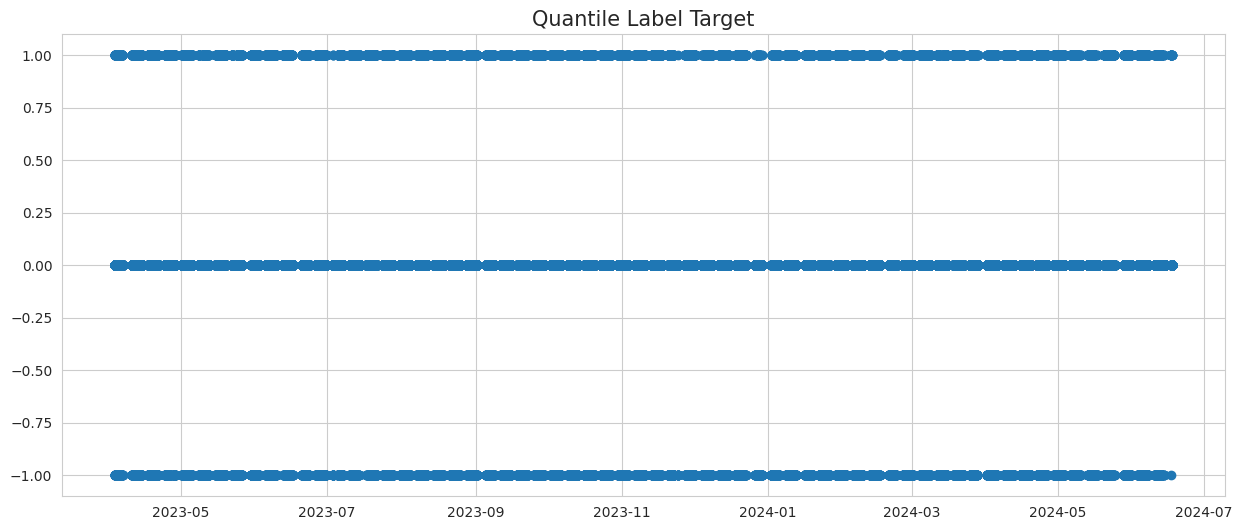

In [354]:
plt.figure(figsize=(15,6))
plt.plot(aapl_train_reg["signal"], "o")
plt.title("Quantile Label Target", size=15)
plt.show()

#### MSFT QUANTILE LABEL TARGET

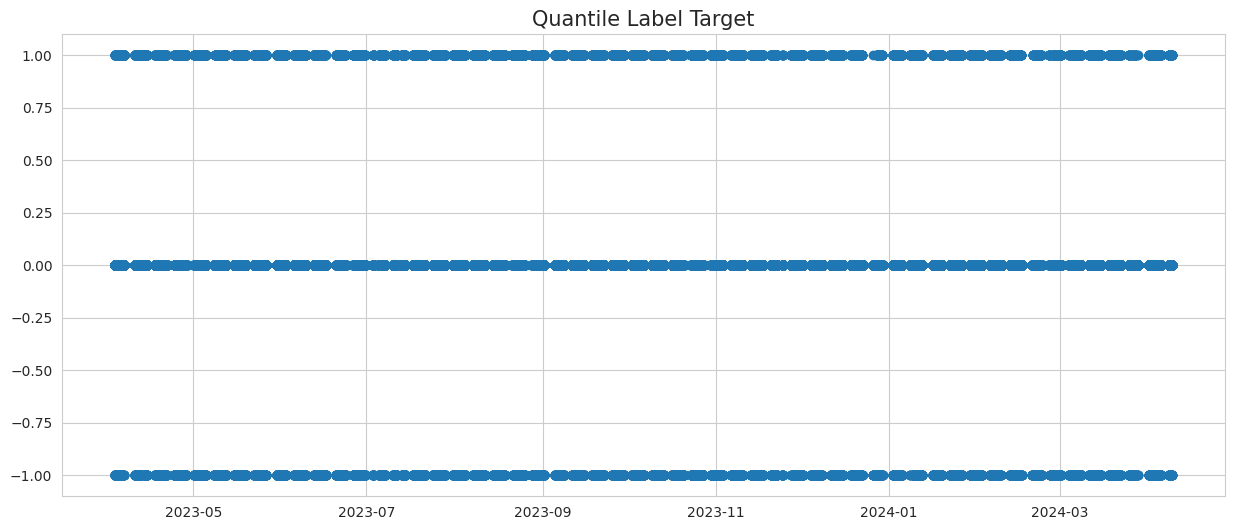

In [355]:
plt.figure(figsize=(15,6))
plt.plot(msft_train_reg["signal"], "o")
plt.title("Quantile Label Target", size=15)
plt.show()

#### SPY QUANTILE LABEL TARGET

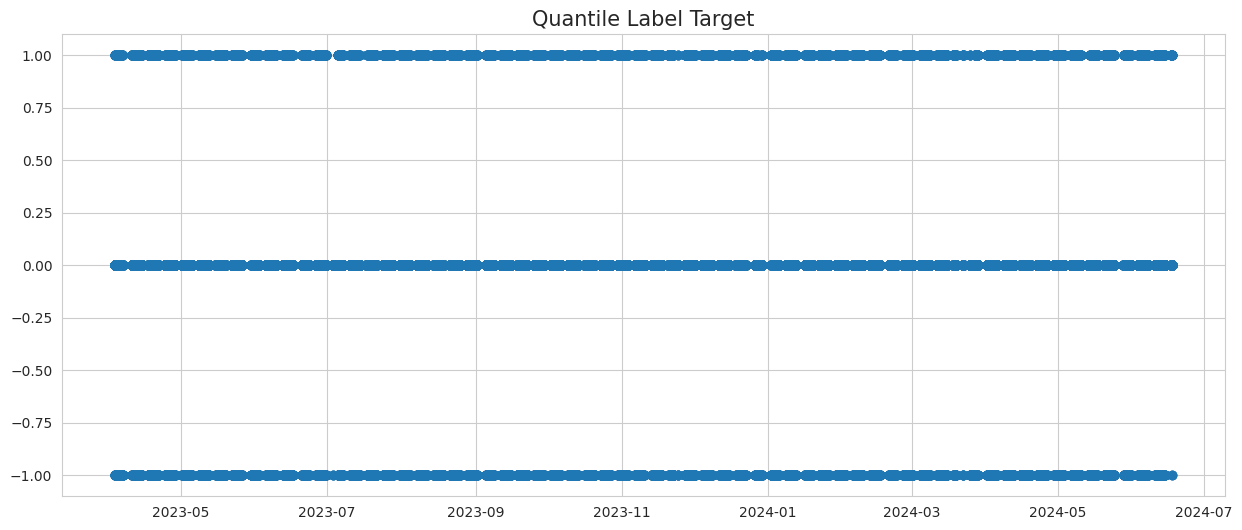

In [356]:
plt.figure(figsize=(15,6))
plt.plot(spy_train_reg["signal"], "o")
plt.title("Quantile Label Target", size=15)
plt.show()

## CHECK CORRELATION

#### SINGLE ASSET CORRELATION

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5]),
 [Text(0.5, 1, 'PCT_EPS_1mo_Open'),
  Text(1.5, 1, 'PCT_EPS_1mo_Close'),
  Text(2.5, 1, 'PCT_EPS_1mo_High'),
  Text(3.5, 1, 'PCT_EPS_1mo_Low'),
  Text(4.5, 1, 'rolling_std'),
  Text(5.5, 1, 'candle_way'),
  Text(6.5, 1, 'filling'),
  Text(7.5, 1, 'amplitude'),
  Text(8.5, 1, 'ROC_change'),
  Text(9.5, 1, 'MOM_change'),
  Text(10.5, 1, '%K_change'),
  Text(11.5, 1, '%D_change'),
  Text(12.5, 1, 'kama_(moving_average)'),
  Text(13.5, 1, 'kama_market_regime_indicator'),
  Text(14.5, 1, 'RSI_change'),
  Text(15.5, 1, 'log_2_return'),
  Text(16.5, 1, 'auto_corr_2'),
  Text(17.5, 1, 'log_5_return'),
  Text(18.5, 1, 'auto_corr_5'),
  Text(19.5, 1, 'log_10_return'),
  Text(20.5, 1, 'auto_corr_10'),
  Text(21.5, 1, 'log_20_return'),
  Text(22.

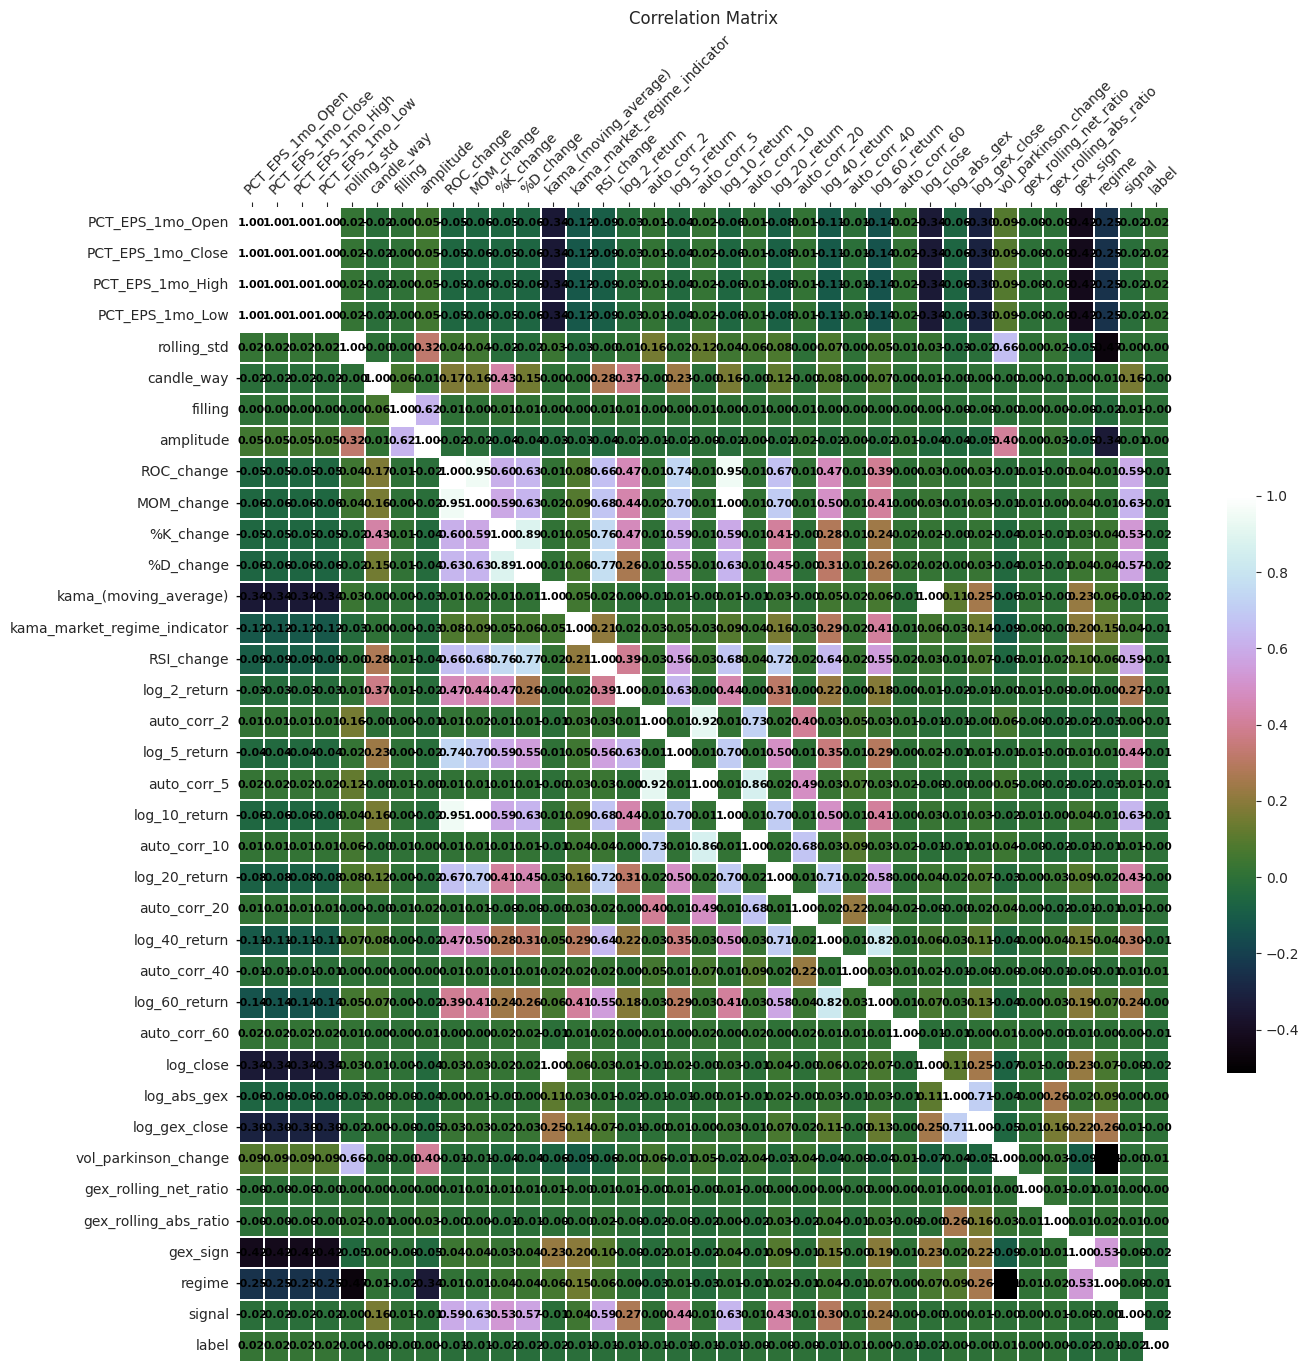

In [357]:
col_drop = ['open','high','low','close','asset_name','label','return','future_return']
list_X = [col for col in aapl_train_reg.columns if col not in col_drop]
X = aapl_train_reg[list_X].iloc[:]
y = aapl_train_reg['label'].iloc[:]

dfc = pd.concat((X,y), axis=1)

correlation = dfc.corr()


plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
heatmap = sns.heatmap(correlation, vmax=1,annot=True,cmap='cubehelix',annot_kws={"size": 8,"color": "black","weight": "bold"},
fmt=".2f",  square=False, linewidths=0.1, cbar_kws={"shrink": 0.5},)
heatmap.xaxis.tick_top()
plt.xticks(rotation=45,ha='left',rotation_mode='anchor',fontsize=10)

#### COMBINED ASSET CORRELATION

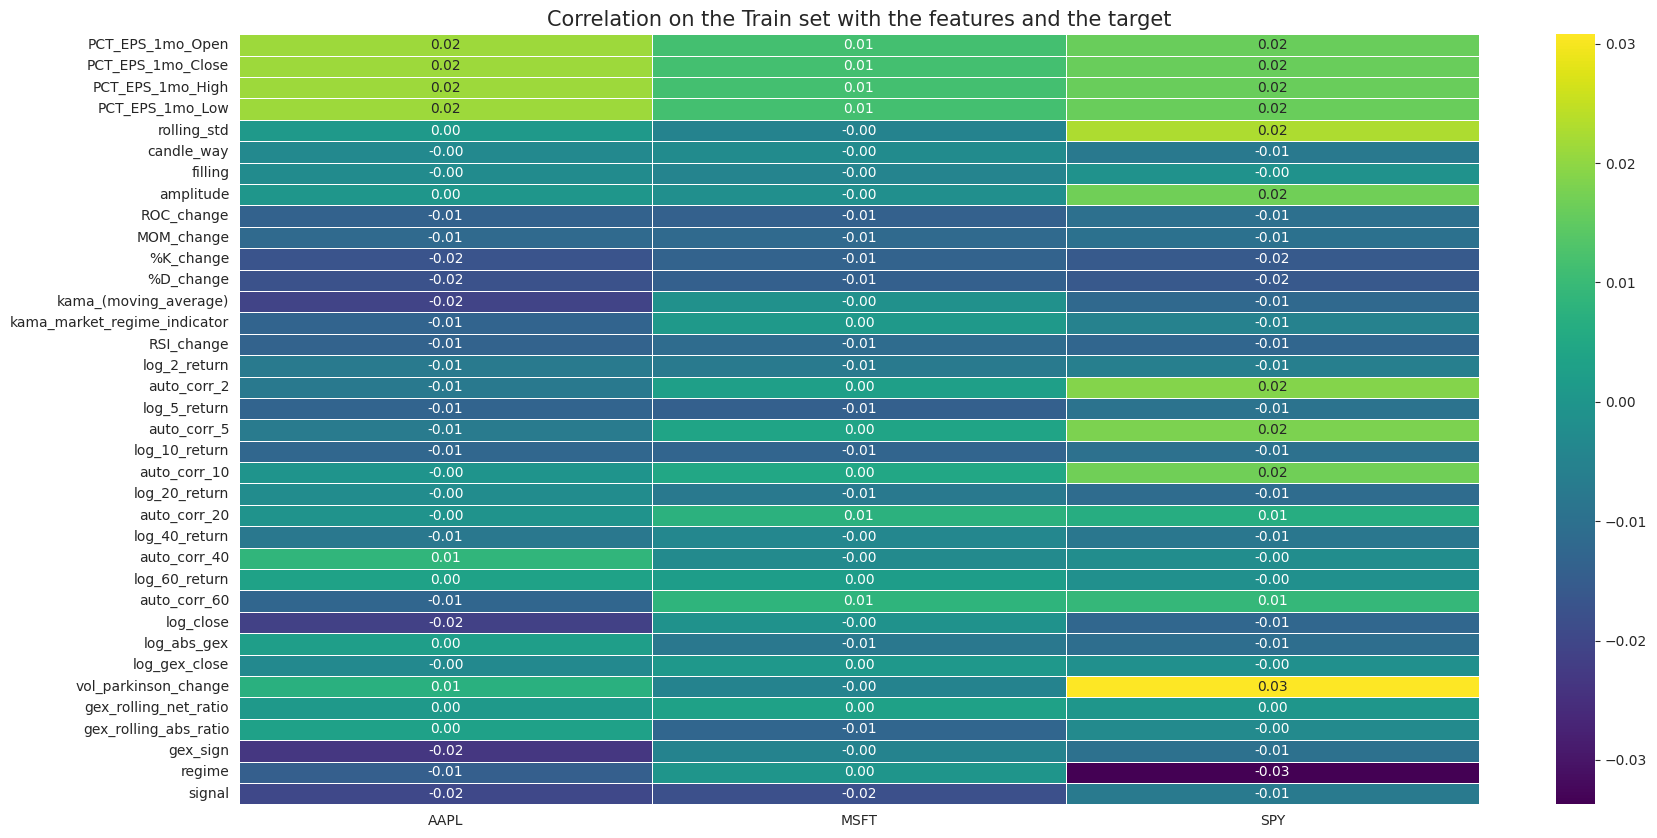

In [358]:
# Make a copy of the dataframe and drop rows with NA values

col_drop = ['open','high','low','close','asset_name','label','return','future_return']
list_X = [col for col in aapl_train_reg.columns if col not in col_drop]
col_y = 'label'

correlations = []
assets = [aapl_train_reg, msft_train_reg, spy_train_reg]
for asset in assets:
    df_copy = asset[list_X + [col_y]].dropna()

    # Create feature matrix X and target vector y
    X = df_copy[list_X].iloc[:-10,:]
    y = df_copy[col_y].iloc[10:]

    dfc = pd.concat((X,y), axis=1)

    correlations.append(dfc.corr()['label'])


correlation = pd.concat(correlations, axis=1)
correlation.columns = ["AAPL", "MSFT", "SPY"]
correlation = correlation.transpose()
del correlation[col_y]
correlation = correlation.transpose()


plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
plt.title("Correlation on the Train set with the features and the target", size=15)
plt.show()

#### DATA IMBALANCE BY UNDERSAMPLING

In [394]:
def correct_imbalance(df, asset_name):
    '''
    this is applied to the train set to perform undersampling

    parameters:
    df: dataframe
    asset_name: str

    returns:
    balanced_df: dataframe

    '''

    sell_df = df[df['label'] == -1].copy()
    hold_df = df[df['label'] == 0].copy()
    buy_df  = df[df['label'] == 1].copy()

    # Print counts just to visualize the imbalance
    print(f"{asset_name} Before: {df['label'].value_counts()}")

    #desired ratio
    target_hold_count = int(min(len(sell_df), len(buy_df)) * 3.5)
    undersampled_hold_df = hold_df.iloc[::int(len(hold_df) / target_hold_count)]

    balanced_df = pd.concat([sell_df, undersampled_hold_df, buy_df])
    balanced_df = balanced_df.sort_index()
    print("")
    print(f"{asset_name} After: {balanced_df['label'].value_counts()}")

    return balanced_df

In [395]:
aapl_balanced_train = correct_imbalance(aapl_train_reg, 'AAPL')
msft_balanced_train = correct_imbalance(msft_train_reg, 'MSFT')
spy_balanced_train = correct_imbalance(spy_train_reg, 'SPY')


AAPL Before: label
 0    92084
-1    11933
 1    11583
Name: count, dtype: int64

AAPL After: label
 0    46042
-1    11933
 1    11583
Name: count, dtype: int64
MSFT Before: label
 0    75790
-1    10368
 1     9824
Name: count, dtype: int64

MSFT After: label
 0    37895
-1    10368
 1     9824
Name: count, dtype: int64
SPY Before: label
 0    90038
-1    13644
 1    11700
Name: count, dtype: int64

SPY After: label
 0    45019
-1    13644
 1    11700
Name: count, dtype: int64


#### SCALE INDIVIDUAL DATA

In [396]:
def custom_percentile_scaler(df_train, df_test, lower=1, upper=99):
    """
    Scales the dataframe using custom percentiles (default: 1st and 99th).
    Similar in spirit to RobustScaler, but with user-defined bounds.

    Parameters:
    df_train (pd.DataFrame): The training dataset.
    df_test (pd.DataFrame): The testing dataset.
    lower (int): The lower percentile (default: 1).
    upper (int): The upper percentile (default: 99).

    Returns:
    scaled_train_data (pd.DataFrame): The scaled training dataset.
    scaled_test_data (pd.DataFrame): The scaled testing dataset.
    """

    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()

    # Store signal columns separately
    train_signal = df_train_copy['label']
    test_signal = df_test_copy['label']


    # Drop signal column for scaling calculations
    train_without_signal = df_train_copy.drop(columns=['label','asset_name'])
    test_without_signal = df_test_copy.drop(columns=['label','asset_name'])

    # Calculate statistics on training data only
    lower_bound = train_without_signal.quantile(lower / 100)
    upper_bound = train_without_signal.quantile(upper / 100)
    median = train_without_signal.median()

    # Scale the data (excluding signal column)
    scaled_train_data = (train_without_signal - median) / (upper_bound - lower_bound)
    scaled_test_data = (test_without_signal - median) / (upper_bound - lower_bound)

    # Add back the signal column
    scaled_train_data['label'] = train_signal
    scaled_test_data['label'] = test_signal



    return scaled_train_data, scaled_test_data

#### COMBINE DATASETS AND APPLY ROBUST STANDARDIZATION

In [397]:
df_combined_train = pd.concat((aapl_balanced_train, msft_balanced_train, spy_balanced_train), axis=0) #combine all train set ready for scaling
df_combined_test = pd.concat((aapl_test_reg, msft_test_reg, spy_test_reg), axis=0) #combine all test set ready for scaling

final_train, final_test = custom_percentile_scaler(df_combined_train, df_combined_test) #apply robust standardization and get final data ready for modelling

## MODEL PREDICTION AND CROSS VALIDATION

#### SINGLE MODEL CHECK

In [398]:
aapl_final_train, aapl_final_test = custom_percentile_scaler(aapl_balanced_train, aapl_train_reg)
spy_final_train, spy_final_test = custom_percentile_scaler(spy_balanced_train, spy_train_reg)
msft_final_train, msft_final_test = custom_percentile_scaler(msft_balanced_train, msft_train_reg)

In [399]:
#RANDOM FOREST

#df = aapl_final_train.copy()
#df = msft_final_train.copy()
#df = spy_final_train.copy()

df = final_train.copy()

col_drop = ['open','high','low','close', 'label','return','asset_name','future_return']
list_X = [col for col in df.columns if col not in col_drop]
col_y = "label"

# Make a copy of the dataframe and drop rows with NA values
df_copy = df[list_X + [col_y]].dropna()
df_copy['label'] = pd.to_numeric(df_copy['label'], errors='coerce')

df_copy = df_copy.dropna()

# Drop rows with inf values (check only numeric columns)
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_copy = df_copy[~np.isinf(df_copy[numeric_cols]).any(axis=1)]

X = df_copy[list_X].iloc[:]
y = df_copy[col_y].iloc[:]

# Split the dataset into training and testing sets
X_train, X_test,  y_train, y_test = train_test_split(
    X,  y, test_size=0.2, random_state=42,shuffle=False)


##INSTANTIATE AND TRAIN MODEL
model = RandomForestClassifier(n_estimators=80, max_depth=10, random_state=42, class_weight='balanced', criterion='gini')
#model = DecisionTreeClassifier(class_weight='balanced')
#model = SVC(kernel="rbf", random_state=2, class_weight='balanced')
model.fit(X_train, y_train)


##PREDICT TEST SET
y_pred = model.predict(X_test)


##CHECK RESULTS
# Classification report (includes precision, recall, f1-score for each class)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# If you want them separately:
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"\nMacro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")


Classification Report:
              precision    recall  f1-score   support

          -1       0.22      0.69      0.34      7225
           0       0.78      0.44      0.56     26210
           1       0.23      0.09      0.13      6167

    accuracy                           0.43     39602
   macro avg       0.41      0.41      0.34     39602
weighted avg       0.59      0.43      0.45     39602


Macro Precision: 0.4121
Macro Recall: 0.4085
Macro F1 Score: 0.3442


#### CHECK FEATURE IMPORTANCE

Text(0.5, 0, 'Variable Importance')

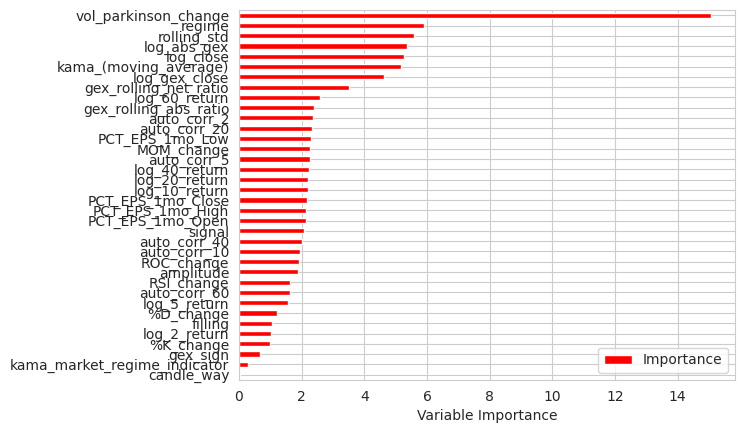

In [400]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0,ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

#### CORSS VALIDATION ACROSS MODELS

In [324]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1,class_weight='balanced')))
models.append(('CART', DecisionTreeClassifier(class_weight='balanced')))
models.append(('RF', RandomForestClassifier(n_jobs=-1, class_weight='balanced')))

#scoring
precision = make_scorer(precision_score, average='macro')
recall = make_scorer(recall_score, average='macro')
f1 = make_scorer(f1_score, average='macro')

#### PERFORM CROSS VALIDATION ACROSS MULTIPLE MODELS

In [401]:
df = final_train.copy()

col_drop = ['open','high','low','close', 'label','return','asset_name','timestamp']
list_X = [col for col in df.columns if col not in col_drop]
col_y = "label"

# Make a copy of the dataframe and drop rows with NA values
df_copy = df[list_X + [col_y]].dropna()
df_copy['label'] = pd.to_numeric(df_copy['label'], errors='coerce')

df_copy = df_copy.dropna()

# Drop rows with inf values (check only numeric columns)
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_copy = df_copy[~np.isinf(df_copy[numeric_cols]).any(axis=1)]

X = df_copy[list_X].iloc[:]
y = df_copy[col_y].iloc[:]

names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    #kfold = KFold(n_splits=num_folds)
    tscv = TimeSeriesSplit(n_splits=10)
    #converted mean squared error to positive. Thelower the better
    cv_results = cross_val_score(model, X, y, cv=tscv, scoring=f1)
    kfold_results.append(cv_results)

    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.840966 (0.094231)
CART: 0.938713 (0.138179)
RF: 0.928015 (0.130977)


#### EVALUATE CROSS VALIDATION RESULT

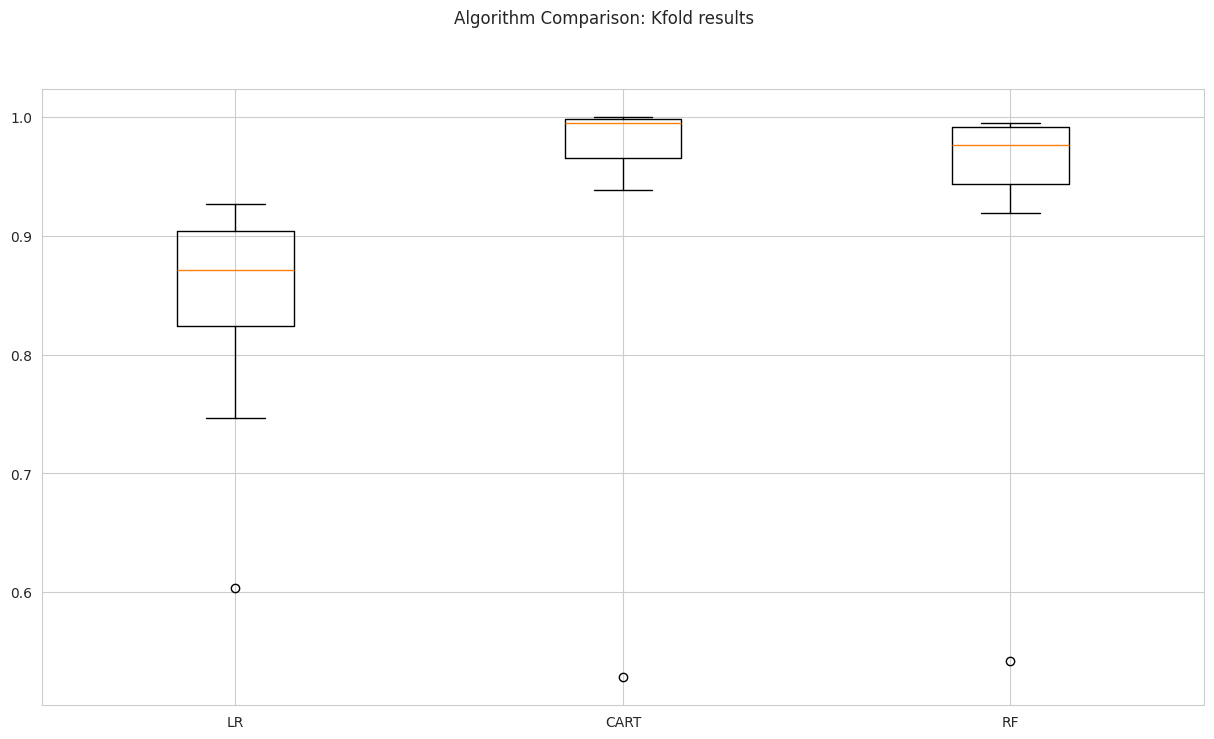

In [402]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

#### MODEL TUNING

In [329]:
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced')
scoring = 'f1_macro'
tscv = TimeSeriesSplit(n_splits=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=tscv)
grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.930693 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


#### RETRAIN MODEL WITH ENTIRE TRAINING SET AND PREDICT UNSEEN TEST SET

In [403]:
#train set
X = df_copy[list_X].iloc[:]  #the final train data
y = df_copy[col_y].iloc[:]


#unseen test set
df_test_final = final_test.copy() #create a copy
df_test_final = df_test_final[list_X + [col_y]].dropna() #select relevant columns/features
df_test_final['label'] = pd.to_numeric(df_test_final['label'], errors='coerce') #ensure label is umeric

df_test_final = df_test_final.dropna() #drop nan values

# Drop rows with inf values (check only numeric columns)
numeric_cols = df_test_final.select_dtypes(include=[np.number]).columns
df_test_final = df_test_final[~np.isinf(df_test_final[numeric_cols]).any(axis=1)]

X_unseen_train = df_test_final[list_X].iloc[:]
y_unseen_test = df_test_final[col_y].iloc[:]

##INSTANTIATE AND TRAIN MODEL
model = RandomForestClassifier(n_estimators=80, max_depth=10, random_state=42, class_weight='balanced', criterion='entropy')
model.fit(X, y)


##PREDICT TEST SET
y_pred = model.predict(X_unseen_train)


##CHECK RESULTS
# Classification report (includes precision, recall, f1-score for each class)
print("\nClassification Report:")
print(classification_report(y_unseen_test, y_pred))

# If you want them separately:
precision_macro = precision_score(y_unseen_test, y_pred, average='macro')
recall_macro = recall_score(y_unseen_test, y_pred, average='macro')
f1_macro = f1_score(y_unseen_test, y_pred, average='macro')

print(f"\nMacro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")


Classification Report:
              precision    recall  f1-score   support

          -1       0.53      0.99      0.69      9464
           0       1.00      0.86      0.92    119557
           1       0.48      0.98      0.64      8011

    accuracy                           0.88    137032
   macro avg       0.67      0.94      0.75    137032
weighted avg       0.94      0.88      0.89    137032


Macro Precision: 0.6691
Macro Recall: 0.9437
Macro F1 Score: 0.7526
